converged SCF energy = -74.4000833840967
Orbital energies:  [-20.30183245  -1.12135975  -0.40314169  -0.31354256  -0.26523287
   0.07346056   0.17476988]
E(FCI) = -74.761661374130
Orbital occupation numbers =  [1.99999993 1.99963241 1.99938882 1.43051086 1.3580934  0.64254228
 0.56983231]
E(FCI HFO) = -74.761661374130
E(FCI BOYS) = -74.761661374142
E(FCI edmiston) = -74.761661374144
E(FCI no) = -74.761661373980


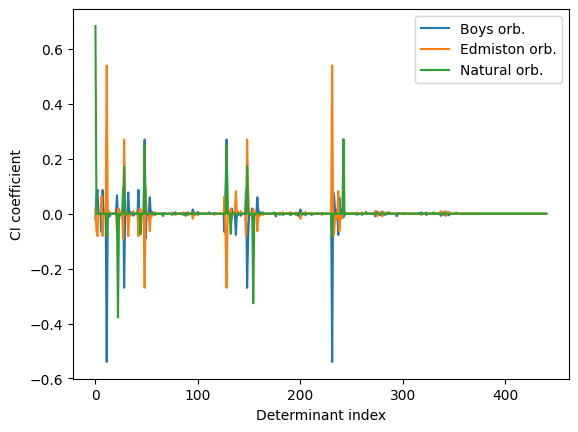

In [16]:
#!/usr/bin/env python
#
# Author: Qiming Sun <osirpt.sun@gmail.com>
#

'''
A simple example to run FCI
'''

import pyscf
from utils import generate_ci_data
import numpy as np
import math
# calculating the CI coefficient
l = 2

sin_alpha_fci = math.sin(52.25 * (math.pi) / 180)
cos_alpha_fci = math.cos(52.25 * (math.pi) / 180)
mol = pyscf.M(
    atom = f'H {l * sin_alpha_fci} {l * cos_alpha_fci} 0; O 0 0 0; H {-l * sin_alpha_fci} {l * cos_alpha_fci} 0',  # in Angstrom
    basis = 'sto3g',
    symmetry = False,
    spin = 0
)
# mol.verbose = 4
mol_1 = mol.copy()
myhf = mol.RHF().run()

# print the orbital energies 
print("Orbital energies: ", myhf.mo_energy)

s1e = myhf.get_ovlp()
# check if HF orbitals are orthogonal
orth_hf = np.dot(myhf.mo_coeff.T, s1e)
orth_hf = np.dot(orth_hf, myhf.mo_coeff)
# print("Orthogonality of HF orbitals: ", orth_hf)
#
# create an FCI solver based on the SCF object
#
cisolver = pyscf.fci.FCI(mol, myhf.mo_coeff)
efci, ci = cisolver.kernel()

print('E(FCI) = %.12f' % efci)
ci = ci.flatten()

import matplotlib.pyplot as plt
# plt.plot(range(len(ci)), ci, label="HF orb.")
#
# create an FCI solver based on the given orbitals and the num. electrons and
# spin of the mol object
#
# try to get some localized orbitals 

boys = pyscf.lo.boys.Boys(mol, myhf.mo_coeff)
mo_boys = boys.kernel()
# orth = np.dot(mo_boys.T, s1e)
# orth = np.dot(orth, mo_boys)
# print("Orthogonality of boys orbitals: ", orth)

cisolver_boys = pyscf.fci.FCI(mol, mo_boys)

#mo_coeff_occ = myhf.mo_coeff[:,myhf.mo_occ>0]
#C = pyscf.lo.iao.iao(myhf.mol, mo_coeff_occ)
## Orthogonalize IAO
#C = pyscf.lo.vec_lowdin(C, s1e)
#C_inv = np.dot(C.conj().T,s1e)
#C_inv_spin = C_inv

#loc_ao_coeff = np.dot(C_inv_spin,myhf.mo_coeff)


efci_boys, ci_boys = cisolver_boys.kernel()
ci_boys = ci_boys.flatten()

plt.plot(range(len(ci_boys)), ci_boys, label="Boys orb.")


edmiston = pyscf.lo.edmiston.Edmiston(mol, myhf.mo_coeff)
mo_edmiston = edmiston.kernel()
# orth_e = np.dot(mo_edmiston.T, s1e)
# orth_e = np.dot(orth_e, mo_edmiston)

# print("Orthogonality of edmiston orbitals: ", orth_e)

cisolver_ed = pyscf.fci.FCI(mol, mo_edmiston)
efci_ed, ci_ed = cisolver_ed.kernel()
ci_ed = ci_ed.flatten()
plt.plot(range(len(ci_ed)), ci_ed, label="Edmiston orb.")

# reshape ci to the original shape

ci_size = int(ci.shape[0]**0.5)
ci_o = ci.reshape(ci_size, ci_size) # ci_o: 21*21 shape
# calculate the 1-body reduced density matrix of the CI wavefunction
rdm1 = cisolver.make_rdm1(ci_o, myhf.mo_coeff.shape[0], mol.nelectron)

# calculate the natural orbitals and their occupation numbers
occ, natural_orbs = np.linalg.eigh(rdm1)

# print(natural_orbs.dot(natural_orbs.T))
# sort the natural orbitals and their occupation numbers
idx = occ.argsort()[::-1]
natural_orbs = natural_orbs[:, idx]
occ = occ[idx]
#print(natural_orbs) 
print("Orbital occupation numbers = ", occ)

no_coeff = np.dot(myhf.mo_coeff, natural_orbs)
#no_coeff = natural_orbs
cisolver_no = pyscf.fci.FCI(mol, no_coeff)

efci_no, ci_no = cisolver_no.kernel()
ci_no = ci_no.flatten()
plt.plot(range(len(ci_no)), ci_no, label="Natural orb.")




print('E(FCI HFO) = %.12f' % efci)
print('E(FCI BOYS) = %.12f' % efci_boys)
print('E(FCI edmiston) = %.12f' % efci_ed)
print('E(FCI no) = %.12f' % efci_no)

plt.xlabel('Determinant index')
plt.ylabel('CI coefficient')
plt.legend()
plt.show()

/tmp/ipykernel_12795/590120366.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(range(len(ci_no)), np.log(abs(ci_no)), label="Natural orb.")


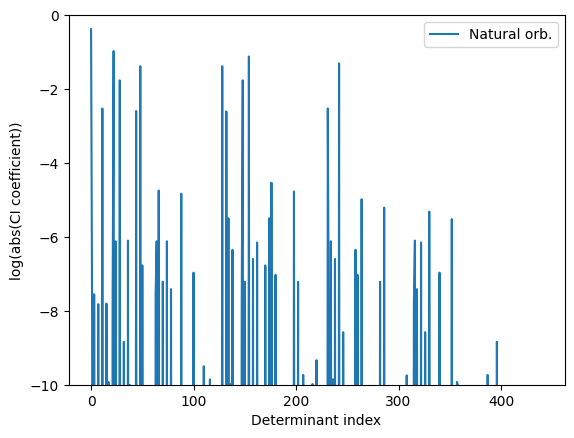

In [3]:
#plt.plot(range(len(ci_ed)), np.log(abs(ci_ed)), label="Edmiston orb.")
plt.plot(range(len(ci_no)), np.log(abs(ci_no)), label="Natural orb.")
#plt.plot(range(len(ci_boys)), np.log(abs(ci_no)), label = "Boys orb.")
plt.xlabel('Determinant index')
plt.ylabel('log(abs(CI coefficient))')
plt.ylim(-10,0)
plt.legend()
plt.show()

/tmp/ipykernel_12795/3569898926.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ci_ab = np.abs(ci_coefficients)


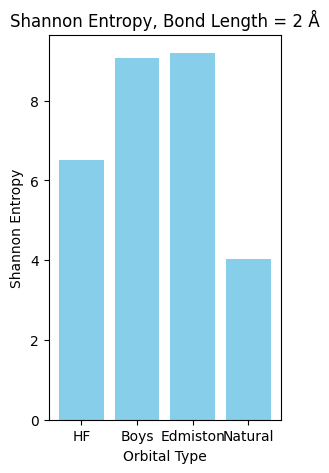

In [17]:
import numpy as np
def calculate_shannon_entropy(ci_coefficients):
    """
    Calculate the Shannon entropy from the CI coefficients.

    Args:
        ci_coefficients (ndarray, flatten): CI coefficients from an FCI calculation.

    Returns:
        float: Shannon entropy of the CI wavefunction.
    """
    
    # no square
    ci_ab = np.abs(ci_coefficients)

    # Normalization
    # ci_ab /= np.sum(ci_ab)

    # Compute the Shannon entropy
    # Only consider non-zero probabilities to avoid log(0) issues
    non_zero_ci = ci_ab[ci_ab > 0]
    entropy = -np.sum(non_zero_ci * np.log(non_zero_ci))

    return entropy



# calculate the entropy for each orbital
e_hf = calculate_shannon_entropy(ci)
e_boys = calculate_shannon_entropy(ci_boys)
e_ed = calculate_shannon_entropy(ci_ed)
ci_no = ci_no.flatten()
e_no = calculate_shannon_entropy(ci_no)


orbital_types = ['HF', 'Boys', 'Edmiston','Natural']
entropy_values = [e_hf, e_boys,  e_ed, e_no]

# Plotting
plt.figure(figsize=(3, 5))
plt.bar(orbital_types, entropy_values, color='skyblue')
plt.xlabel('Orbital Type')
plt.ylabel('Shannon Entropy')
plt.title(f'Shannon Entropy, Bond Length = {l} Å')
plt.show() 


WARN: HOMO 0.8307667507414277 > LUMO -0.2681633252886693 was found in the canonicalized orbitals.

converged SCF energy = -72.7962270249882
Orbital energies:  [-18.3666539    0.02759864   0.82730282   0.82932142   0.83076675
  -0.26816333  -0.26815285]
E(FCI) = -74.737324150002


/tmp/ipykernel_7566/1424329398.py:85: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(range(len(ci_ed)), np.log(abs(ci_ed)), label="Edmiston orb.")


Orthogonality of pipek orbitals:  [[ 1.00000000e+00 -2.81925780e-17  2.84248526e-16 -9.61217577e-18
   4.09849729e-19  3.37683920e-19 -2.14099537e-18]
 [-8.34200171e-17  1.00000000e+00 -6.82395921e-17 -2.44577003e-16
  -2.00098889e-18 -1.53700741e-18 -5.53066352e-18]
 [ 2.84346840e-16 -6.81315201e-17  1.00000000e+00  8.61658704e-17
  -2.38749766e-17  5.31019271e-17  1.82706999e-18]
 [-9.35620709e-18 -2.50239218e-16  8.61141288e-17  1.00000000e+00
  -9.26440838e-17  1.98231499e-17  6.50008332e-17]
 [ 5.29939882e-19 -2.12824341e-18 -2.38883994e-17 -9.26184412e-17
   1.00000000e+00 -8.36796196e-19 -9.27143741e-19]
 [ 3.32421767e-19 -1.58112095e-18  5.30058058e-17  1.99107303e-17
  -8.36742162e-19  1.00000000e+00  1.49998540e-17]
 [-2.13278893e-18 -5.54036140e-18  1.80856841e-18  6.50014089e-17
  -9.27063368e-19  2.55450297e-17  1.00000000e+00]]
Orbital occupation numbers =  [2.         1.99999972 1.83827564 1.16216473 1.00000983 1.
 0.99955008]


/tmp/ipykernel_7566/1424329398.py:126: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(range(len(ci_no)), np.log(abs(ci_no)), label="Natural orb.")


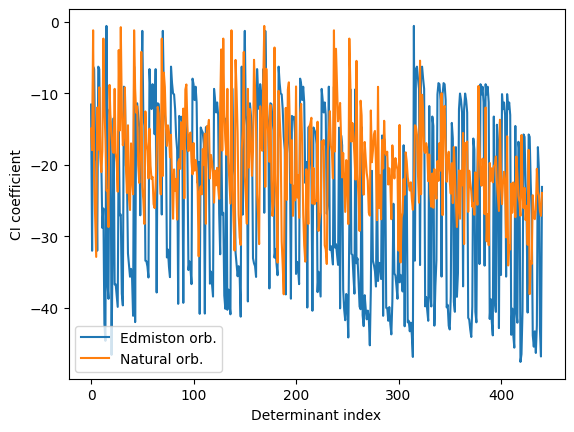

E(FCI HFO) = -74.737324150002
E(FCI BOYS) = -74.737331805994
E(FCI edmiston) = -74.737331805986
E(FCI pipek) = -74.737324197966
E(FCI no) = -74.737321438614


In [5]:
#!/usr/bin/env python
#
# Author: Qiming Sun <osirpt.sun@gmail.com>
#

'''
A simple example to run FCI
'''
import math
import pyscf
from utils import generate_ci_data
import numpy as np
sin_alpha_fci = math.sin(52.25 * (math.pi) / 180)
cos_alpha_fci = math.cos(52.25 * (math.pi) / 180)
l = 3.7
mol = pyscf.M(
    atom = f'H {l * sin_alpha_fci} {l * cos_alpha_fci} 0; O 0 0 0; H {-l * sin_alpha_fci} {l * cos_alpha_fci} 0',  # in Angstrom
    basis = 'sto3g',
    symmetry = False,
    spin = 0
)

# mol.verbose = 4
myhf = mol.RHF().newton().run()

# print the orbital energies 
print("Orbital energies: ", myhf.mo_energy)

s1e = myhf.get_ovlp()
# check if HF orbitals are orthogonal
orth_hf = np.dot(myhf.mo_coeff.T, s1e)
orth_hf = np.dot(orth_hf, myhf.mo_coeff)
# print("Orthogonality of HF orbitals: ", orth_hf)
#
# create an FCI solver based on the SCF object
#
cisolver = pyscf.fci.FCI(mol, myhf.mo_coeff)
efci, ci = cisolver.kernel()

print('E(FCI) = %.12f' % efci)
ci = ci.flatten()

import matplotlib.pyplot as plt
# plt.plot(range(len(ci)), ci, label="HF orb.")
#
# create an FCI solver based on the given orbitals and the num. electrons and
# spin of the mol object
#
# try to get some localized orbitals 

boys = pyscf.lo.boys.Boys(mol, myhf.mo_coeff)
mo_boys = boys.kernel()
orth = np.dot(mo_boys.T, s1e)
orth = np.dot(orth, mo_boys)
# print("Orthogonality of boys orbitals: ", orth)

cisolver_boys = pyscf.fci.FCI(mol, mo_boys)

#mo_coeff_occ = myhf.mo_coeff[:,myhf.mo_occ>0]
#C = pyscf.lo.iao.iao(myhf.mol, mo_coeff_occ)
## Orthogonalize IAO
#C = pyscf.lo.vec_lowdin(C, s1e)
#C_inv = np.dot(C.conj().T,s1e)
#C_inv_spin = C_inv

#loc_ao_coeff = np.dot(C_inv_spin,myhf.mo_coeff)


efci_boys, ci_boys = cisolver_boys.kernel()
ci_boys = ci_boys.flatten()

# plt.plot(range(len(ci_boys)), ci_boys, label="Boys orb.")


edmiston = pyscf.lo.edmiston.Edmiston(mol, myhf.mo_coeff)
mo_edmiston = edmiston.kernel()
# orth_e = np.dot(mo_edmiston.T, s1e)
# orth_e = np.dot(orth_e, mo_edmiston)

# print("Orthogonality of edmiston orbitals: ", orth_e)

cisolver_ed = pyscf.fci.FCI(mol, mo_edmiston)
efci_ed, ci_ed = cisolver_ed.kernel()
ci_ed = ci_ed.flatten()
plt.plot(range(len(ci_ed)), np.log(abs(ci_ed)), label="Edmiston orb.")



pipek = pyscf.lo.pipek.Pipek(mol, myhf.mo_coeff)
mo_pipek = pipek.kernel()
orth_p = np.dot(mo_pipek.T, s1e)
orth_p = np.dot(orth_p, mo_pipek)

print("Orthogonality of pipek orbitals: ", orth_p)

cisolver_pi = pyscf.fci.FCI(mol, mo_pipek)
efci_pi, ci_pi = cisolver_pi.kernel()
ci_pi = ci_pi.flatten()
# plt.plot(range(len(ci_pi)), ci_pi, label="Pipek orb.")


# reshape ci to the original shape

ci_size = int(ci.shape[0]**0.5)
ci_o = ci.reshape(ci_size, ci_size) # ci_o: 21*21 shape
# calculate the 1-body reduced density matrix of the CI wavefunction
rdm1 = cisolver.make_rdm1(ci_o, myhf.mo_coeff.shape[0], mol.nelectron)

# calculate the natural orbitals and their occupation numbers
occ, natural_orbs = np.linalg.eigh(rdm1)

# print(natural_orbs.dot(natural_orbs.T))
# sort the natural orbitals and their occupation numbers
idx = occ.argsort()[::-1]
natural_orbs = natural_orbs[:, idx]
occ = occ[idx]
#print(natural_orbs) 
print("Orbital occupation numbers = ", occ)

no_coeff = np.dot(myhf.mo_coeff, natural_orbs)
#no_coeff = natural_orbs
cisolver_no = pyscf.fci.FCI(mol, no_coeff)

efci_no, ci_no = cisolver_no.kernel()
ci_no = ci_no.flatten()
plt.plot(range(len(ci_no)), np.log(abs(ci_no)), label="Natural orb.")

plt.xlabel('Determinant index')
plt.ylabel('CI coefficient')
plt.legend()
plt.show()


print('E(FCI HFO) = %.12f' % efci)
print('E(FCI BOYS) = %.12f' % efci_boys)
print('E(FCI edmiston) = %.12f' % efci_ed)
print('E(FCI pipek) = %.12f' % efci_pi)
print('E(FCI no) = %.12f' % efci_no)



/tmp/ipykernel_7566/3565108138.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(range(len(ci_ed)), np.log(abs(ci_ed)), label="Edmiston orb.")
/tmp/ipykernel_7566/3565108138.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.plot(range(len(ci_no)), np.log(abs(ci_no)), label="Natural orb.")


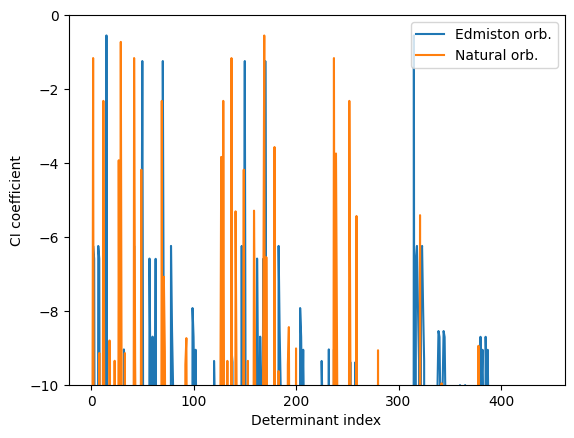

In [10]:
import numpy as np
from warnings import warn

def shannon(spec):
    '''
    Shannon entropy of a probability distribution

    Args:
        spec (ndarray): probability distribution
    
    Returns:
        S (float): Shannon entropy of spec
    '''
    spec = np.asarray(spec)
    if np.any(spec < 0):
        if np.any(np.abs(spec[spec < 0]) > 1e-6):
            warn("Warning: spec has negative entries!")
    elif np.any(spec > 1):
        print(spec)
        raise ValueError("spec has entries larger than 1")
    spec = spec[spec > 0]
    return -np.sum(spec * np.log(spec)) 

def get_cost_fqi(gamma, Gamma, inactive_indices):

    '''
    Sum of all inactive orbital entropy

    Args:
        gamma (ndarray): current 1RDM
        Gamma (ndarray): current 2RDM
        inactive_indices (list): indices of inactive orbitals
    
    Returns:
        cost_fun (float): S(rho_i) for all i in inactive_indices

    '''


    inds = np.asarray(inactive_indices) 
    nu = gamma[2*inds, 2*inds]
    nd = gamma[2*inds+1, 2*inds+1]
    nn = Gamma[inds, inds, inds, inds]
    spec = np.array([1-nu-nd+nn, nu-nn, nd-nn, nn])
    cost_fun = shannon(spec)
    
    return np.sum(cost_fun)

def prep_rdm12(dm1, dm2):
    '''
    Prepare the 1- and 2-RDM (splitting 1-RDM into spin parts and fix prefactor of 2-RDM)
    This only works for singlet states.
    For other spin states, one should run spin unrestricted DMRG and get the 
    spin 1- and 2-RDMs.

    Args:
        dm1 (ndarray): spatial-orbital 1RDM from pyscf
        dm2 (ndarray): spatial-orbital 2RDM from pyscf

    Returns:
        rdm1(ndarray): prepared 1RDM in spin-orbital indices
        rdm2(ndarray): prepared relevant part of the 2RDM in orbital indices and spin (up,down,down,up)
    '''
    no = len(dm1)
    rdm1 = np.zeros((2*no, 2*no))
    rdm1[::2, ::2] = dm1 / 2
    rdm1[1::2, 1::2] = dm1 / 2
    rdm2 = dm2.transpose((0,2,3,1)).copy()
    rdm2 = (2 * rdm2 + rdm2.transpose((0, 1, 3, 2))) / 6.

    return rdm1,rdm2

In [11]:
import pyscf
import numpy as np
import matplotlib.pyplot as plt
import math

import pyscf.fci

def make_no(cisolver, ci, myhf, mo_coeff=None):
    if mo_coeff is None:
        mo_coeff = myhf.mo_coeff
    rdm1_fci = cisolver.make_rdm1(ci, myhf.mo_coeff.shape[0], myhf.mol.nelectron)
    occ_fci, natural_orbs_fci = np.linalg.eigh(rdm1_fci)
    idx_fci = occ_fci.argsort()[::-1]
    natural_orbs_fci = natural_orbs_fci[:, idx_fci]
    no_coeff_fci = np.dot(mo_coeff, natural_orbs_fci)
    return no_coeff_fci


sin_alpha_fci = math.sin(52.25 * (math.pi) / 180)
cos_alpha_fci = math.cos(52.25 * (math.pi) / 180)

# Range of bond lengths to explore (e.g., from 0.9 to 1.2 Angstrom)
bond_lengths_fci = np.arange(2.0,2.1, 0.1)
entropies = []
energies = []
von_entropies = []
total_entropies = []
# Loop over bond lengths
for l in bond_lengths_fci:
    mol = pyscf.M(
        atom = f'H {l * sin_alpha_fci} {l * cos_alpha_fci} 0; O 0 0 0; H {-l * sin_alpha_fci} {l * cos_alpha_fci} 0',  # in Angstrom
        basis = 'sto3g',
        symmetry = False,
        spin = 0
    )
# how to control the convergence on pyscf
    # Perform Hartree-Fock calculation
    
    myhf = pyscf.scf.RHF(mol)
    myhf.diis_space = 16
    # myhf.init_guess = 'minao' 
    myhf.conv_tol = 1e-14
    # myhf.verbose = 4
    myhf.max_cycle = 2000
    myhf.kernel()
    
    hf_fci = pyscf.fci.FCI(mol, myhf.mo_coeff)
    hf_fci.verbose = 5
    hf_fci.conv_tol = 1e-15
    hf_fci.max_cycle = 2500
    hf_fci.max_space = 500
    e_hf_fci, ci_hf = hf_fci.kernel()

    # Calculate the full 1-RDM
    
    
    mo_coeffs = []
    names_of_orbitals = ['HF', 'Boys', 'Edmiston', 'Natural']
    # construct different types of orbitals 
    mo_coeffs.append(myhf.mo_coeff.copy())
    mo_coeffs.append(pyscf.lo.boys.Boys(mol, myhf.mo_coeff).kernel())
    mo_coeffs.append(pyscf.lo.edmiston.Edmiston(mol, myhf.mo_coeff).kernel())
    
    ed_fci = pyscf.fci.FCI(mol, mo_coeffs[2])
    ed_fci.verbose = 5
    ed_fci.conv_tol = 1e-15
    ed_fci.max_cycle = 2500
    ed_fci.max_space = 500
    e_ed_fci, ci_ed = ed_fci.kernel()
    mo_coeffs.append(make_no(ed_fci, ci_ed, myhf, mo_coeffs[2]))

    entropies_ = []
    energies_ = []
    von_entropies_ = []
    total_entropies_ = []
    for mo in mo_coeffs:
        cisolver_fci = pyscf.fci.FCI(mol, mo)
        # cisolver_fci.verbose = 5
        cisolver_fci.conv_tol = 1e-14
        #cisolver_fci.conv_tol_normt = 1e-8
        cisolver_fci.max_cycle = 1500
        cisolver_fci.max_space = 500
        efci_fci, ci_fci = cisolver_fci.kernel()
        print(efci_fci)
        ci_fci = ci_fci.flatten()
        full_rdm1 = cisolver_fci.make_rdm1(ci_fci, mo.shape[0], myhf.mol.nelectron)
        full_rdm2 = cisolver_fci.make_rdm2(ci_fci, mo.shape[0], myhf.mol.nelectron)
        list_orbs = np.arange(len(mo))
        full_rdm1, full_rdm2 = prep_rdm12(full_rdm1, full_rdm2)
        
        total_entropy = get_cost_fqi(full_rdm1, full_rdm2, list_orbs)
        entropies_.append(calculate_shannon_entropy(ci_fci))
        total_entropies_.append(total_entropy)
        energies_.append(efci_fci)
    entropies.append(entropies_)
    energies.append(energies_)
    total_entropies.append(total_entropies_)
energies = np.array(energies)
entropies = np.array(entropies)
total_entropies = np.array(total_entropies)

converged SCF energy = -74.4000833841032
davidson 0 1  |r|= 0.437  e= [-78.79559911]  max|de|= -78.8  lindep=    1
davidson 1 2  |r|= 0.264  e= [-79.03775803]  max|de|= -0.242  lindep= 0.992
davidson 2 3  |r|= 0.104  e= [-79.12930386]  max|de|= -0.0915  lindep= 0.982
davidson 3 4  |r|= 0.062  e= [-79.14206053]  max|de|= -0.0128  lindep= 0.995
davidson 4 5  |r|= 0.0626  e= [-79.14806815]  max|de|= -0.00601  lindep= 0.987
davidson 5 6  |r|= 0.0385  e= [-79.15435092]  max|de|= -0.00628  lindep= 0.992
davidson 6 7  |r|= 0.0171  e= [-79.15568951]  max|de|= -0.00134  lindep= 0.993
davidson 7 8  |r|= 0.0163  e= [-79.15612966]  max|de|= -0.00044  lindep= 0.954
davidson 8 9  |r|= 0.0148  e= [-79.156744]  max|de|= -0.000614  lindep= 0.97
davidson 9 10  |r|= 0.00743  e= [-79.15701033]  max|de|= -0.000266  lindep= 0.976
davidson 10 11  |r|= 0.00768  e= [-79.15709874]  max|de|= -8.84e-05  lindep= 0.981
davidson 11 12  |r|= 0.00373  e= [-79.15716261]  max|de|= -6.39e-05  lindep= 0.987
davidson 12 13

/tmp/ipykernel_12795/2179197511.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ci_ab = np.abs(ci_coefficients)


-74.76166137416202
-74.76166137416209
-74.76166137416212
converged SCF energy = -74.3510529374571
davidson 0 1  |r|= 0.32  e= [-78.54658748]  max|de|= -78.5  lindep=    1
davidson 1 2  |r|= 0.396  e= [-78.68729667]  max|de|= -0.141  lindep= 0.992
davidson 2 3  |r|= 0.204  e= [-78.87055868]  max|de|= -0.183  lindep= 0.999
davidson 3 4  |r|= 0.0778  e= [-78.91661434]  max|de|= -0.0461  lindep= 0.996
davidson 4 5  |r|= 0.0525  e= [-78.92481256]  max|de|= -0.0082  lindep= 0.984
davidson 5 6  |r|= 0.0603  e= [-78.93221068]  max|de|= -0.0074  lindep= 0.995
davidson 6 7  |r|= 0.0324  e= [-78.93548861]  max|de|= -0.00328  lindep= 0.976
davidson 7 8  |r|= 0.0167  e= [-78.93639836]  max|de|= -0.00091  lindep= 0.969
davidson 8 9  |r|= 0.0308  e= [-78.93731723]  max|de|= -0.000919  lindep= 0.934
davidson 9 10  |r|= 0.0245  e= [-78.93898636]  max|de|= -0.00167  lindep= 0.987
davidson 10 11  |r|= 0.00969  e= [-78.93958191]  max|de|= -0.000596  lindep= 0.974
davidson 11 12  |r|= 0.00618  e= [-78.9397

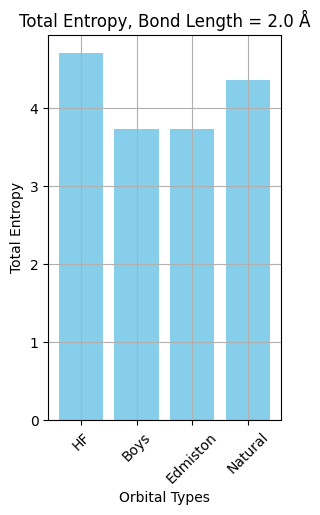

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you've calculated the total entropies for each orbital
# when bond length is 2.0 Å (or any specific length you are interested in).

# List of names of the orbitals
orbital_labels = ['HF', 'Boys', 'Edmiston', 'Natural']

# The bond length you are interested in (e.g., 2.0 Å)
target_bond_length = 2.0

# Find the index of the target bond length
target_index = np.where(np.isclose(bond_lengths_fci, target_bond_length))[0][0]

# Extract total entropies corresponding to the target bond length
total_entropies_at_target_length = total_entropies[target_index]

# Plotting
plt.figure(figsize=(3, 5))
plt.bar(orbital_labels, total_entropies_at_target_length, color='skyblue')
plt.xlabel('Orbital Types')
plt.ylabel('Total Entropy')
plt.title(f'Total Entropy, Bond Length = {target_bond_length} Å')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


In [9]:
print(total_entropies)

[[0.16885137 5.2052069  6.19789582 0.16209366]
 [0.25280585 5.37221273 6.17803523 0.2413893 ]]


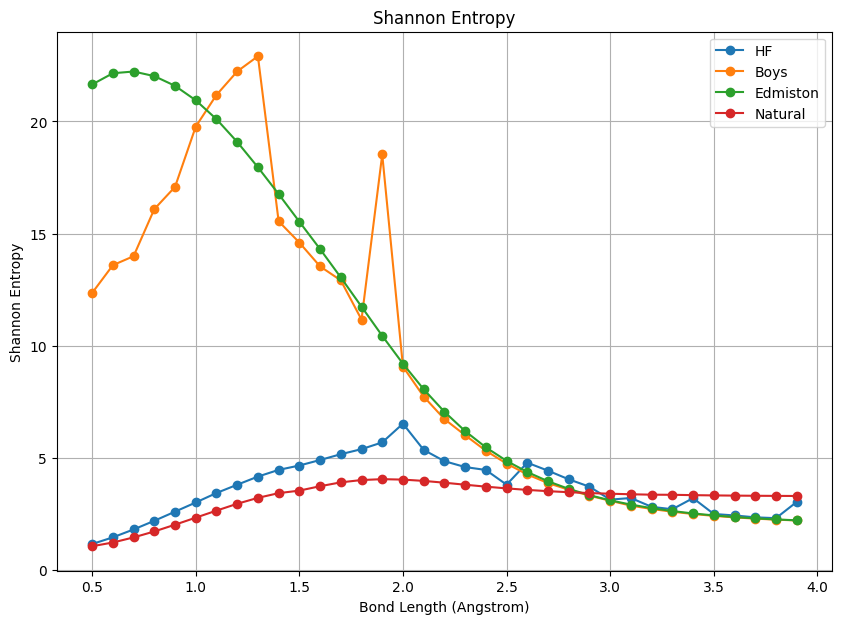

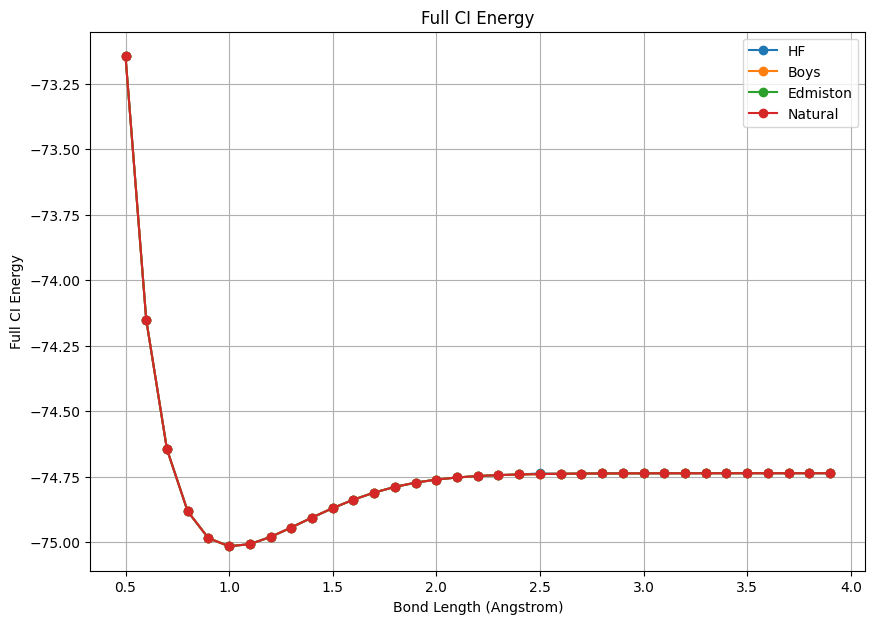

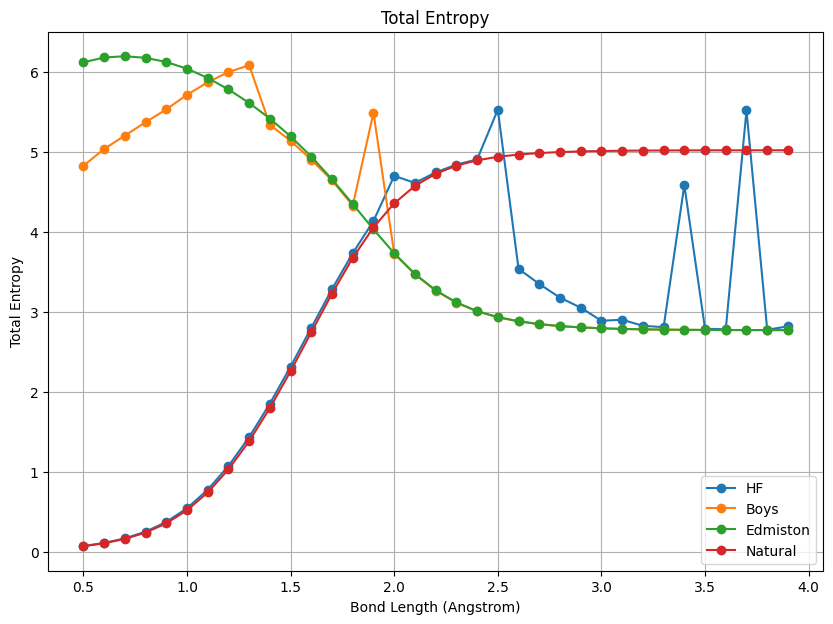

In [9]:
# simplify the plotting by using plotting function
import matplotlib.pyplot as plt

def plot_data(bond_lengths, data, names_of_orbitals, y_label, title):
    """
    Plot the data for different orbitals.

    Parameters:
    bond_lengths (list or ndarray): The x-axis values (e.g., bond lengths).
    data (ndarray): The y-axis values for different orbitals (shape: (n_orbitals, n_points)).
    names_of_orbitals (list): The labels for different orbitals.
    y_label (str): The label for the y-axis.
    title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 7))
    
    for i, o in enumerate(data.T):
        plt.plot(bond_lengths, o, marker='o', label=names_of_orbitals[i])
    
    plt.xlabel("Bond Length (Angstrom)")
    plt.ylabel(y_label)
    # plt.ylim(-10,4)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot
names_of_orbitals = ['HF', 'Boys', 'Edmiston', 'Natural']
plot_data(bond_lengths_fci, entropies, names_of_orbitals, "Shannon Entropy", "Shannon Entropy")
plot_data(bond_lengths_fci, energies, names_of_orbitals, "Full CI Energy", "Full CI Energy")
plot_data(bond_lengths_fci, total_entropies, names_of_orbitals, "Total Entropy", "Total Entropy")


# Plotting different data

['HF', 'Boys', 'Edmiston', 'Natural']
[1.80358476 2.18964717]
[13.9904265  16.08870956]
[22.22606996 22.02134751]
[1.44841453 1.7140814 ]


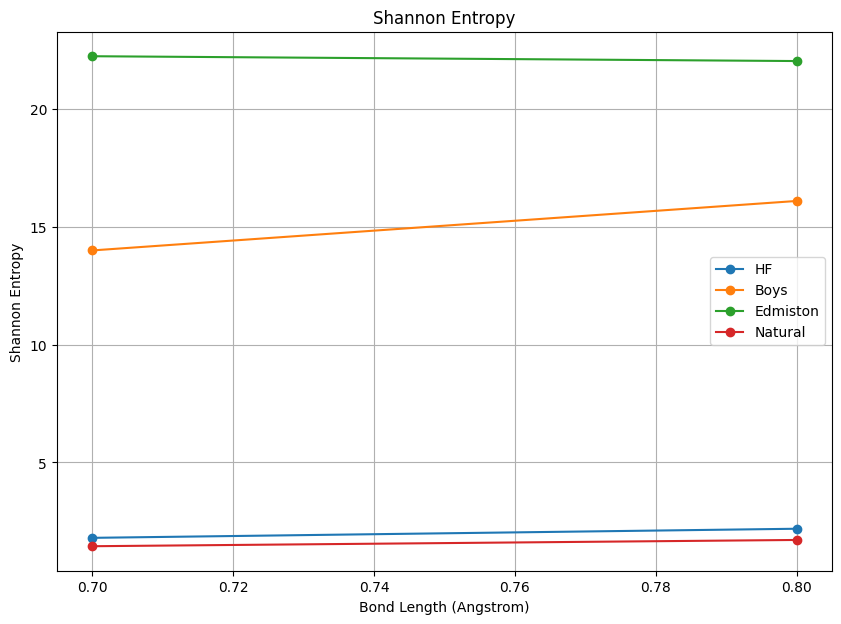

[-74.64604329 -74.88274832]
[-74.64604329 -74.88274832]
[-74.64604329 -74.88274832]
[-74.64604329 -74.88274832]


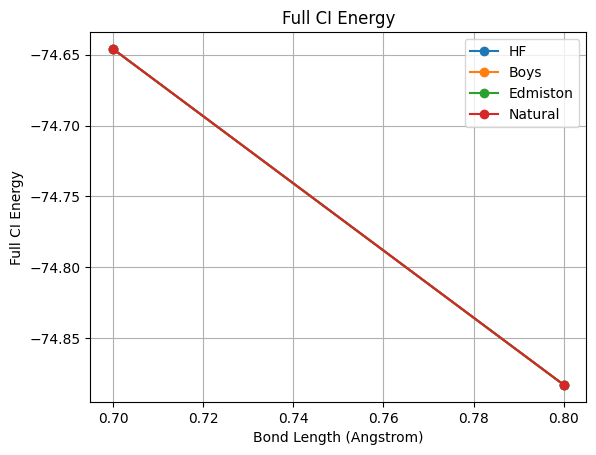

[0.16885137 0.25280585]
[5.2052069  5.37221273]
[6.19789582 6.17803523]
[0.16209366 0.2413893 ]


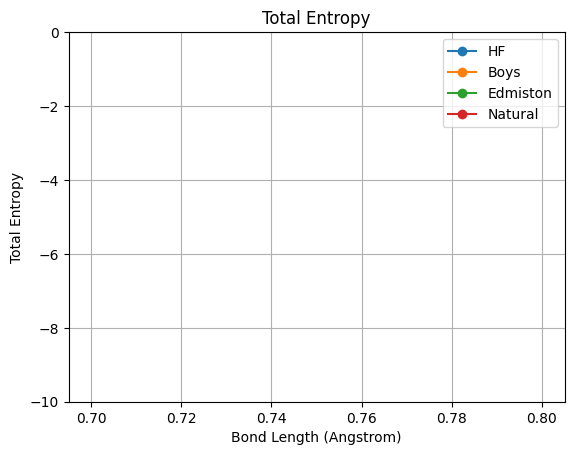

In [11]:
# Plotting the Shannon Entropy
names_of_orbitals = ['HF', 'Boys', 'Edmiston', 'Natural']
plt.figure(figsize=(10, 7))
print(names_of_orbitals)
for i, o in enumerate(entropies.T):
    print(o)
    plt.plot(bond_lengths_fci, o, marker='o', label=names_of_orbitals[i])

plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Shannon Entropy")
plt.title("Shannon Entropy")
plt.legend()
plt.grid(True)
plt.show()

for i, c in enumerate(energies.T):
    print(c)
    plt.plot(bond_lengths_fci, c, marker='o', label=names_of_orbitals[i])
    
    
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Full CI Energy")
# plt.ylim(-74.8, -74.7)
plt.title("Full CI Energy")
plt.legend()
plt.grid(True)
plt.show()


for i, c in enumerate(total_entropies.T):
    print(c)
    plt.plot(bond_lengths_fci, c, marker='o', label=names_of_orbitals[i])
    
    
plt.xlabel("Bond Length (Angstrom)")
plt.ylabel("Total Entropy")
plt.ylim(-10, -0)
plt.title("Total Entropy")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
boys_coeff_t = pyscf.lo.boys.Boys(mol, myhf.mo_coeff).kernel()
edmiston_coeff_t = pyscf.lo.edmiston.Edmiston(mol, myhf.mo_coeff).kernel()
no_coeff_t = make_no(ed_fci, ci_ed, myhf, mo_coeffs[2])
print(f'Number of Spatial Orbitals for edmiston: {edmiston_coeff_t.shape[1]}')
print(f'Number of Spatial Orbitals for boys: {boys_coeff_t.shape[1]}')
print(f'Number of Spatial Orbitals for no_coeff: {no_coeff_t.shape[1]}')


Number of Spatial Orbitals for edmiston: 7
Number of Spatial Orbitals for boys: 7
Number of Spatial Orbitals for no_coeff: 7


In [13]:
number_of_determinant = math.comb(14, 10)
print(f'FCI Number of Determinants:{number_of_determinant}')

FCI Number of Determinants:1001
